In [5]:
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import geopandas as gpd
import pandas as pd
import sklearn

In [6]:
data_dir = '/Users/jyontika/Desktop/opioid-overdose-models/cook-county/cleaning-cook-county/'
csv_path = os.path.join(data_dir, 'cook_county_gdf_quarterly.csv')
cook_county_gdf = pd.read_csv(csv_path) 

In [7]:
cook_county_gdf.year.isna().sum()

56

In [8]:
#add in missing 58 tracts
cook_county_gdf['quarter'].fillna(9999, inplace=True)
cook_county_gdf['year'].fillna(9999, inplace=True)

In [9]:
cook_county_gdf.loc[cook_county_gdf['year'] == 9999, 'geoid'].nunique()

56

In [10]:
columns_to_keep = ['STATEFP', 'COUNTYFP', 'TRACTCE','NAME', 'NAMELSAD', 'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER',
       'INTPTLAT', 'INTPTLON', 'geometry']

gdf_quarter = cook_county_gdf.groupby(['geoid', 'quarter', 'year']).agg({'deaths': 'sum', **{col: 'first' for col in columns_to_keep}}).reset_index()

### Making DF square - one quarter for each tract


In [12]:
gdf_quarter.loc[gdf_quarter['year'] == 9999, 'deaths'] = 0
gdf_quarter.loc[gdf_quarter['quarter'] == 9999, 'deaths'] = 0

# Replace 9999 with 2015 in the 'year' column
gdf_quarter['year'].replace(9999, 2015, inplace=True)
gdf_quarter['quarter'].replace(9999, 1, inplace=True)

In [13]:
gdf_quarter['geoid'].nunique()  #1332

1332

In [14]:
##uses nested for loops - not exactly the most efficient 
years = range(2015, 2024)
quarters = range(1, 5)

existing_combinations = set(zip(gdf_quarter['geoid'], gdf_quarter['year'], gdf_quarter['quarter']))
updated_rows = []

for tract in gdf_quarter['geoid'].unique():
    for year in years:
        for quarter in quarters:
            combination = (tract, year, quarter)
            if combination not in existing_combinations:
                new_row = {'geoid': tract, 'year': year, 'quarter': quarter, 'deaths': 0}
                updated_rows.append(new_row)

gdf_quarter = pd.concat([gdf_quarter, pd.DataFrame(updated_rows)], ignore_index=True)


In [15]:
#fills in NAs produced from above
unique_tracts = gdf_quarter['geoid'].unique()

for tract in unique_tracts:
    tract_rows = gdf_quarter[gdf_quarter['geoid'] == tract]
    non_na_row = tract_rows.dropna().iloc[0]  # Get the first row without any NAs
    
    for column in columns_to_keep:
        gdf_quarter.loc[(gdf_quarter['geoid'] == tract) & gdf_quarter[column].isna(), column] = non_na_row[column]

In [16]:
gdf_quarter.shape #should be (48148, 16)


(48148, 16)

In [17]:
gdf_quarter['geoid'].nunique()  #should be 1332

1332

In [18]:
#confirms all years and quarters present
years = range(2015, 2024) 
quarters = range(1, 5)  

for geoid in gdf_quarter['geoid'].unique():
    for year in years:
        for quarter in quarters:
            if not ((gdf_quarter['geoid'] == geoid) & (gdf_quarter['year'] == year) & (gdf_quarter['quarter'] == quarter)).any():
                print("Missing row for geoid {} in year {} quarter {}".format(geoid, year, quarter))



In [19]:
#Any NAs in data frame?

has_na = gdf_quarter.isna().any().any()

if has_na:
    print("There are missing values in the dataframe.")
else:
    print("There are no missing values in the dataframe.")


There are no missing values in the dataframe.


In [20]:
#Any Duplicates?
has_duplicates = gdf_quarter.duplicated().any()

if has_duplicates:
    print("There are duplicate rows in the dataframe.")
else:
    print("There are no duplicate rows in the dataframe.")


There are no duplicate rows in the dataframe.


In [21]:
#change format of year and quarters

gdf_quarter['year'] = pd.to_datetime(gdf_quarter['year'].astype(int).astype(str), format='%Y').dt.year
gdf_quarter['quarter'] = gdf_quarter['quarter'].astype(str).replace('1.0', '1').replace('2.0', '2').replace('3.0', '3').replace('4.0', '4')


In [22]:
gdf_quarter.columns

Index(['geoid', 'quarter', 'year', 'deaths', 'STATEFP', 'COUNTYFP', 'TRACTCE',
       'NAME', 'NAMELSAD', 'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT',
       'INTPTLON', 'geometry'],
      dtype='object')

In [23]:
gdf_quarter.columns = ['geoid', 'quarter', 'year', 'deaths', 'STATEFP', 'COUNTYFP', 'TRACTCE',
       'NAME', 'NAMELSAD', 'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER', 'lat',
       'lon', 'geometry']

In [24]:
#take out 2014 and 2023
gdf_quarter = gdf_quarter[gdf_quarter['year'] != 2023]
gdf_quarter = gdf_quarter[gdf_quarter['year'] != 2014]

In [25]:
#create timestep column
gdf_quarter = gdf_quarter.sort_values(by=['geoid', 'quarter'])

# Group the data by 'geoid' and use 'cumcount' to create the 'timestep' column.
gdf_quarter['timestep'] = gdf_quarter.groupby('geoid').cumcount() + 1


In [26]:
#convert back to gdf
from shapely import wkt

gdf_quarter['geometry'] = gdf_quarter['geometry'].apply(wkt.loads)

gdf_quarter = gpd.GeoDataFrame(gdf_quarter, geometry='geometry')
gdf_quarter.crs = {'init': 'EPSG:4269'}
type(gdf_quarter)

/Users/jyontika/Library/Python/3.9/lib/python/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


geopandas.geodataframe.GeoDataFrame

<Axes: >

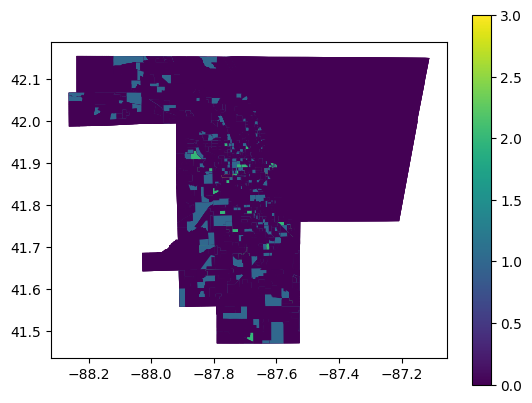

In [27]:
gdf_quarter[gdf_quarter['year']==2015].plot('deaths', legend=True)


### store gdf

In [28]:
csv_dir = 'cook_county_gdf_quarterly.csv'
output_path = os.path.join(data_dir, csv_dir)

# Save GeoDataFrames to CSV files
gdf_quarter.to_csv(output_path, index=False)